In [1]:
#bibliotecas pandas de leitura de arquivos
import pandas as pd
#biblioteca do kmeans
from sklearn.cluster import KMeans
import numpy as np
#avaliar classificacao cluster
#from sklearn.metrics.cluster import adjusted_rand_score
#visualizar graficos
import matplotlib.pyplot as plt
#caracter 
import re
#countar os itens de uma lista
from collections import Counter
#separar treino, teste, validação
from sklearn.model_selection import train_test_split
# métricas de avaliação do K-Means
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
# Método Silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from IPython.display import Image
from pathlib import Path


In [2]:
#  Bibliotecas do Dendograma

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler


In [3]:
# Definição de diretórios e Disco de leitura dos arquivos (Desktop ou Notebook) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIR_MODIFICADO = DIRETORIO_PRINCIPAL / "dataset_modificado"
DIR_KMEANS = DIRETORIO_PRINCIPAL / "KMeansRandom"

#DIRETORIO_DATASET = DIR_PREFIXO / "Projeto_PA"


In [4]:
#leitura dao Dataset completo com dados cadastrais, medidas, doença e estatísticas

dataset = pd.read_csv(DIRETORIO_PRINCIPAL / "padrao_doenca" / "classificados_por_padroes_de_doenca_estatistica.csv",sep=';')
numeros_identificacao = dataset["numero_identificacao"]
dataset.set_index("numero_identificacao", drop=True, inplace=True)

In [5]:

# dataset

In [6]:
############################### FUNÇÕES ##########################################

#Funções para calcular o melhor numero de cluster(grupos) que seu dataset gerar

def calculate_wcss(data):
    """
    Calcula a soma dos quadrados intra-clusters para 19
    quantidades de clusters, iniciando com o mínimo de 2 clusters
    
    Parametros
    ----------
    data : DataFrame
        conjunto de dados para fazer o `.fit()` do KMeans

    
    Returns
    -------
    wcss : lista contendo os valores de soma de quadrados intra-cluster
    """
    from sklearn.cluster import KMeans
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    """
    Calcula a maior distância entre os pontos que marcam as 
    somas dos quadrados intra-clusters para 19 calculadas 
    com `calculate_wcss()`
    
    Parametros
    ----------
    wcss : lista
        lista contendo os valores de soma de quadrados intra-cluster

    
    Returns
    -------
    int : número de clusters 
    """
    from math import sqrt
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2

#converter peso em float
def Tratar_Peso(peso):    
    
    try:
        if peso[-1] == ',' or peso[-1] == '.':
            peso =  peso[:-1]
    except:
        pass
    
    
    try:
        peso = float(peso)
    except:
        peso = float(peso.replace(',','.'))
    return peso

#converter altura
def Tratar_Altura(altura):       
       
    
    if re.match('\d,,\d', altura):
        altura = altura.replace(',,','')
    
    try:
        if altura[-1] == ',' or altura[-1] == '.' or  altura[-1] == ']':
            altura =  altura[:-1]
    except:
        pass
    
    try:
        altura = float(altura)
    except:
        altura = float(altura.replace(',','.'))     
    
    # convt 150.00 para 1.50
    if altura >= 3:
        altura = altura/100 
    
    
    return altura

#calcular o IMC
def IMC(peso,altura):  
        
    imc = float(peso) / (float(altura) * float(altura))
    
    return imc


#Trocar  True para 1 e False para 0
def verdadeiro_falso(valor):
    if valor == True:
        return 1
    else:
        return 0

In [7]:
# Identificando dados espúrios no campo altura e descartando
dataset = dataset[dataset['altura']!= '?']

#filtrar nulos em peso e altura
dataset = dataset[~dataset['peso'].isnull() & ~dataset['altura'].isnull()]

In [8]:
# Normalizando Peso e Altura
dataset['peso_normalizado'] = dataset['peso'].apply(Tratar_Peso)
dataset['altura_normalizada'] = dataset['altura'].apply(Tratar_Altura)

In [9]:
#calculo do IMC
dataset['IMC'] = dataset.apply(lambda row : IMC(row['peso_normalizado'], row['altura_normalizada']), axis = 1)


In [10]:
dataset

,data_nascimento,genero,idade,peso,altura,data_exame,sist 9:00,sist 9:15,sist 9:30,sist 9:45,...,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica,peso_normalizado,altura_normalizada,IMC
numero_identificacao,,,,,,,,,,,,,,,,,,,,,
4,1923-10-05,M,94.0,85.0,160,2018-09-10 12:25:23,105.0,108.0,116.0,104.0,...,4902.0,3748.0,841.5,16.52,11.36,11,34,85.0,1.60,33.203125
5,1948-10-07,M,70.0,80.0,165,2018-12-26 07:39:41,103.0,114.0,82.0,104.0,...,5034.5,2915.0,606.0,7.51,6.65,9,23,80.0,1.65,29.384757
6,1999-03-23,M,19.0,100.0,197,2018-12-26 08:06:19,147.0,148.0,156.0,140.0,...,6154.0,3721.0,751.5,12.70,13.01,19,19,100.0,1.97,25.767219
7,1978-01-26,F,40.0,65.0,"1,64",2018-12-26 08:19:06,140.0,139.0,142.0,137.0,...,6420.5,3642.0,602.5,16.13,10.34,21,9,65.0,1.64,24.167162
8,1990-03-07,M,28.0,120.0,172,2018-12-26 08:26:59,NaN,110.0,101.0,108.0,...,6118.0,2405.0,566.0,12.27,12.79,10,11,120.0,1.72,40.562466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21786,1972-11-25,M,47.0,75.0,165,2020-09-10 16:03:08,163.0,198.0,172.0,148.0,...,9265.0,2439.0,474.5,18.66,14.80,49,60,75.0,1.65,27.548209
21787,1970-10-19,M,49.0,90.0,183,2020-09-10 16:21:02,114.0,120.0,164.0,116.0,...,6819.0,3319.0,738.0,17.22,13.67,32,27,90.0,1.83,26.874496
21788,1985-03-15,F,35.0,93.0,167,2020-09-10 16:44:53,107.0,110.0,103.0,NaN,...,4935.5,3556.0,713.5,14.36,8.29,14,26,93.0,1.67,33.346481


# Abordagem 1: Medidas como entrada

In [11]:
#selecionando variaveis sist 9:00 a diast 8:45
#campos sist e diast
ls_sist_diast = list(dataset.loc[:,'sist 9:00':'diast 8:45'].columns)
dados_sist_diast = dataset.loc[:,'sist 9:00':'diast 8:45']

In [12]:
#tratar nulos
# Verificar melhor forma de tratar os NaN - o método 'ffill' replic a ultima metida válida
#dados_sist_diast_sem_nan = dados_sist_diast.fillna(method="ffill", axis=1)
#dados_sist_diast_sem_nan = dados_sist_diast.fillna(method="bfill", axis=1)

dados_sist_diast_sem_nan = dados_sist_diast.fillna(value=0)
dados_sist_diast_sem_nan.loc[12:13]
#dados_sist_diast

,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
numero_identificacao,,,,,,,,,,,,,,,,,,,,,
12,0.0,118.0,122.0,125.0,0.0,0.0,0.0,124.0,120.0,116.0,...,71.0,79.0,78.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,129.0,111.0,0.0,0.0,0.0,0.0,...,58.0,99.0,140.0,67.0,81.0,95.0,0.0,0.0,0.0,0.0


In [13]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares = calculate_wcss(dados_sist_diast_sem_nan)
num_otimo_clusters = optimal_number_of_clusters(sum_of_squares)
print (num_otimo_clusters)

Wall time: 2min 45s
8


In [14]:
#convertendo os dados para a clusterização
X = np.array(dados_sist_diast_sem_nan)

In [15]:
#habilitando o kmeans com 8 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=num_otimo_clusters, random_state=0).fit(X)

In [16]:
#listar os grupos 
grupos = kmeans.fit_predict(X)

In [17]:
#incluir grupos nos dados de sist e diast
dados_sist_diast_sem_nan['grupo'] = grupos

In [18]:
dados_sist_diast_sem_nan.index = dataset.index
dados = dados_sist_diast_sem_nan.copy()
dados_sist_diast.loc[12]

sist 9:00       NaN
sist 9:15     118.0
sist 9:30     122.0
sist 9:45     125.0
sist 10:00      NaN
              ...  
diast 7:45      NaN
diast 8:00      NaN
diast 8:15      NaN
diast 8:30      NaN
diast 8:45      NaN
Name: 12, Length: 164, dtype: float64

In [19]:
# Cria um "multi-indice": podemos recuperar os grupos simplesmente colocando o numero do grupo como indice:

indices = pd.concat([pd.Series(grupos, name="Grupo", dtype="int"), dataset.index.to_series(index=range(len(dataset)))], axis=1)
indices = pd.MultiIndex.from_frame(indices)
indices
dados.index = indices
dados.loc[(2,12), ]
#dados

sist 9:00       0.0
sist 9:15     118.0
sist 9:30     122.0
sist 9:45     125.0
sist 10:00      0.0
              ...  
diast 8:00      0.0
diast 8:15      0.0
diast 8:30      0.0
diast 8:45      0.0
grupo           2.0
Name: (2, 12), Length: 165, dtype: float64

### Dendograma da Clusterização das Medidas (Abordagem 1)

In [20]:
#  Plota o Dendograma

#scaler = StandardScaler()
#dados_para_dendograma = scaler.fit_transform(grupos)
#
#dendrograma = dendrogram(linkage(dados_para_dendograma, method = 'ward'))
#plt.title('Dendrograma')
#plt.xlabel('Pessoas')
#plt.ylabel('Distância Euclidiana')
#
#hc = AgglomerativeClustering(n_clusters = num_otimo_clusters, affinity = 'euclidean', linkage = 'ward')
#previsoes = hc.fit_predict(dados_para_dendograma)

## O método Elbow

### Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico

### https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

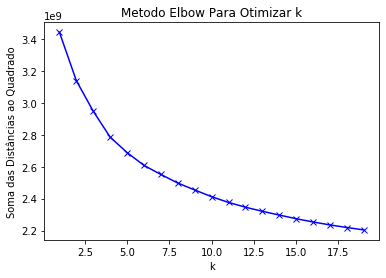

Wall time: 102 ms


In [21]:
#metodo de Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k')
fig = plt.gcf() 
%time plt.show()

In [22]:
fig.savefig('D:\Projeto_PA\\Projeto_PA_validado\\KMeansRandom\\graficos\\grafico_metodoelbow_medidas.svg', format='svg')

#fig.savefig('diastolica_sistolica/diast_sist_elbow.png', format='png')


# Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.10238735387075767
Para n_clusters = 3 O score_silhouette medio e : 0.08779496052084497
Para n_clusters = 4 O score_silhouette medio e : 0.08352976216818586
Para n_clusters = 5 O score_silhouette medio e : 0.08211587357670115
Para n_clusters = 6 O score_silhouette medio e : 0.085161872497417
Para n_clusters = 7 O score_silhouette medio e : 0.07651851778878796
Para n_clusters = 8 O score_silhouette medio e : 0.06789289264048608


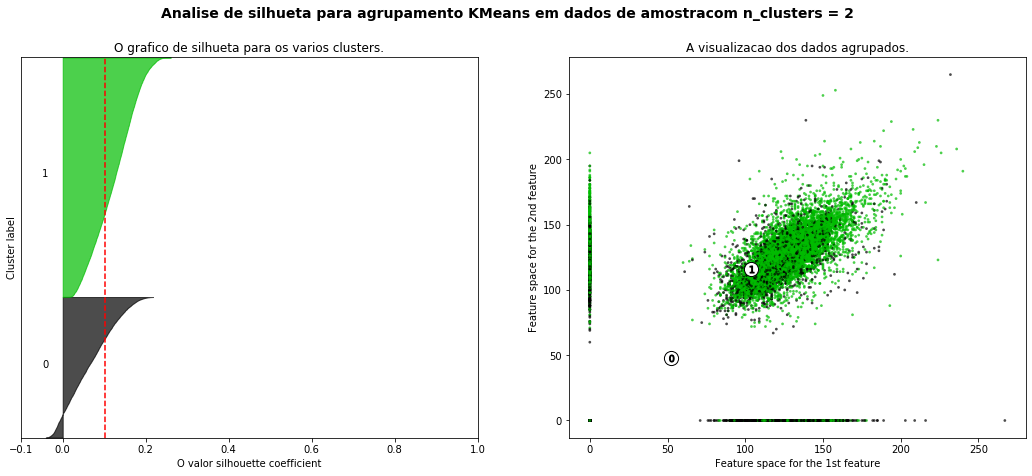

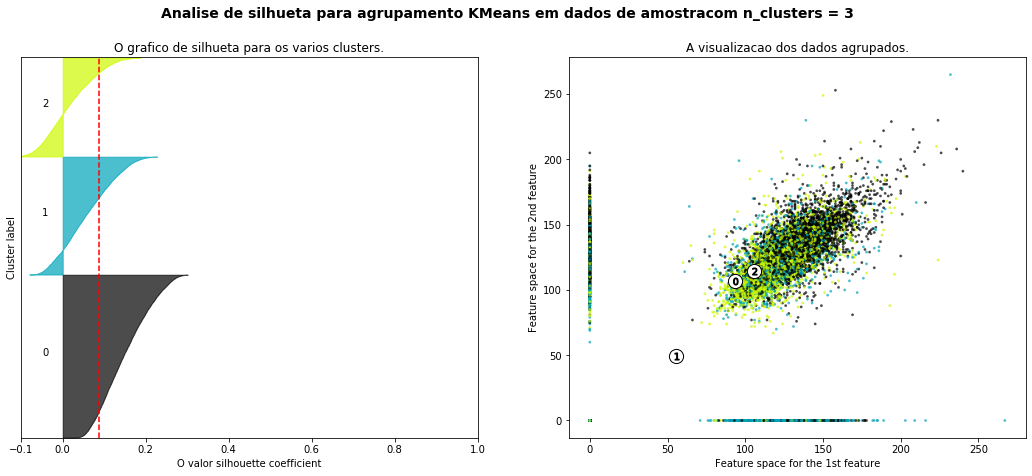

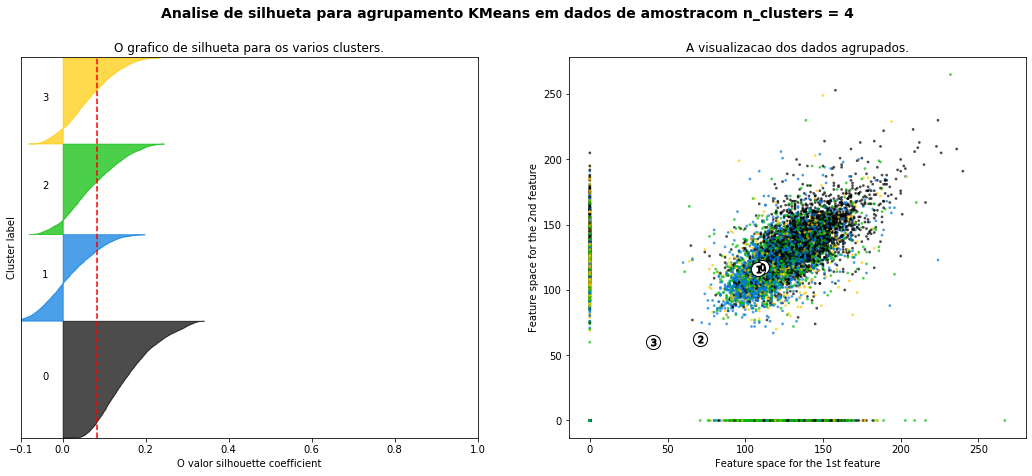

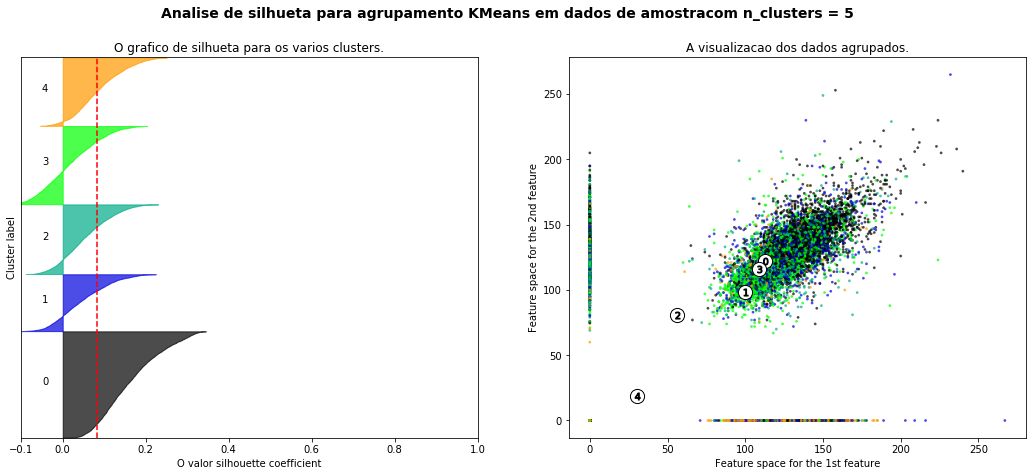

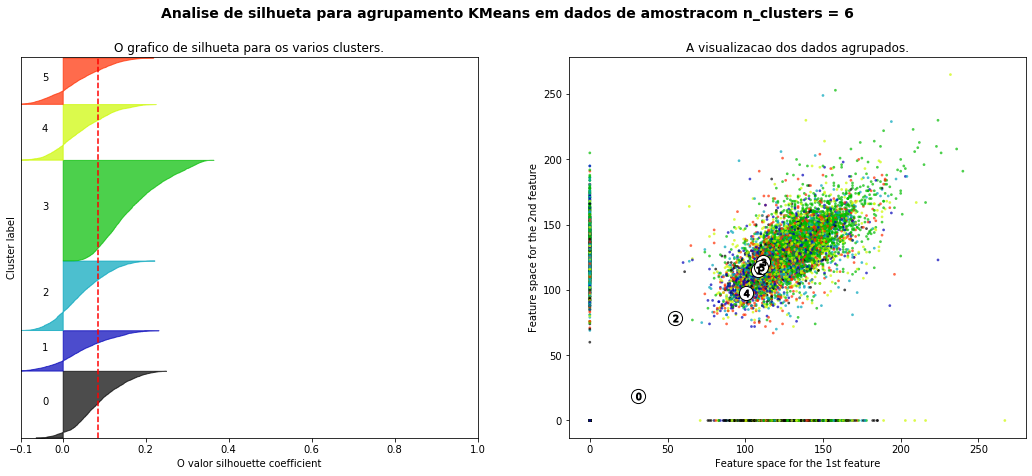

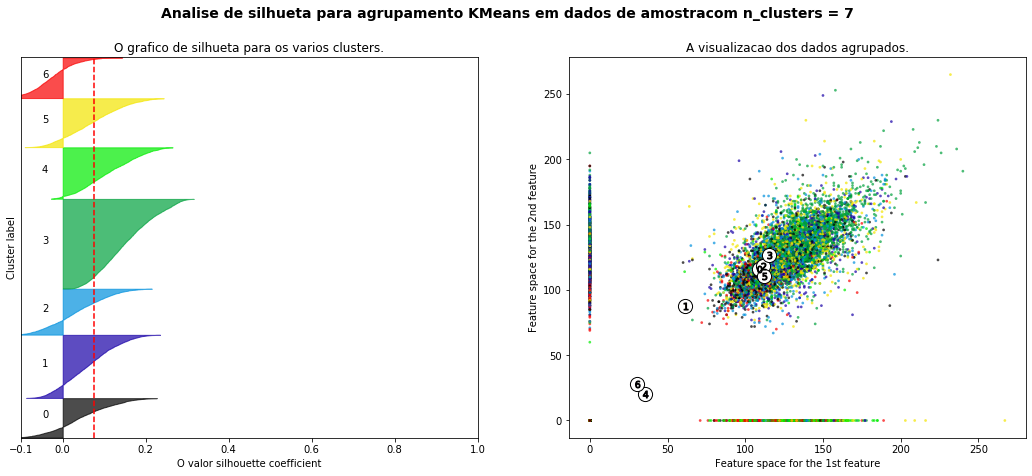

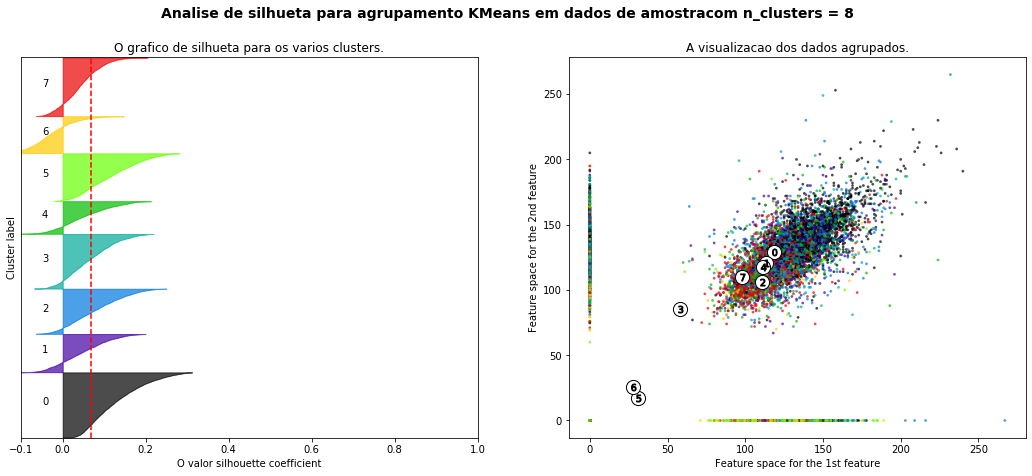

In [23]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans em dados de amostra"
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_medidas_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando 

In [24]:
#dataset com grupos e por medidas
dataset_s_d = dataset
dataset_s_d['grupos'] = grupos
dataset_s_d

,data_nascimento,genero,idade,peso,altura,data_exame,sist 9:00,sist 9:15,sist 9:30,sist 9:45,...,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica,peso_normalizado,altura_normalizada,IMC,grupos
numero_identificacao,,,,,,,,,,,,,,,,,,,,,
4,1923-10-05,M,94.0,85.0,160,2018-09-10 12:25:23,105.0,108.0,116.0,104.0,...,3748.0,841.5,16.52,11.36,11,34,85.0,1.60,33.203125,3
5,1948-10-07,M,70.0,80.0,165,2018-12-26 07:39:41,103.0,114.0,82.0,104.0,...,2915.0,606.0,7.51,6.65,9,23,80.0,1.65,29.384757,3
6,1999-03-23,M,19.0,100.0,197,2018-12-26 08:06:19,147.0,148.0,156.0,140.0,...,3721.0,751.5,12.70,13.01,19,19,100.0,1.97,25.767219,7
7,1978-01-26,F,40.0,65.0,"1,64",2018-12-26 08:19:06,140.0,139.0,142.0,137.0,...,3642.0,602.5,16.13,10.34,21,9,65.0,1.64,24.167162,7
8,1990-03-07,M,28.0,120.0,172,2018-12-26 08:26:59,NaN,110.0,101.0,108.0,...,2405.0,566.0,12.27,12.79,10,11,120.0,1.72,40.562466,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21786,1972-11-25,M,47.0,75.0,165,2020-09-10 16:03:08,163.0,198.0,172.0,148.0,...,2439.0,474.5,18.66,14.80,49,60,75.0,1.65,27.548209,5
21787,1970-10-19,M,49.0,90.0,183,2020-09-10 16:21:02,114.0,120.0,164.0,116.0,...,3319.0,738.0,17.22,13.67,32,27,90.0,1.83,26.874496,5
21788,1985-03-15,F,35.0,93.0,167,2020-09-10 16:44:53,107.0,110.0,103.0,NaN,...,3556.0,713.5,14.36,8.29,14,26,93.0,1.67,33.346481,5


In [25]:
# Salva dataset com dados completos após o K-Means com abordagem 1 (medidas)
dataset_s_d.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

#dataset_s_d.to_csv('diastolica_sistolica/dataset_sistolica_diastolica.csv')

### Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=100)

In [28]:
#base para modelo

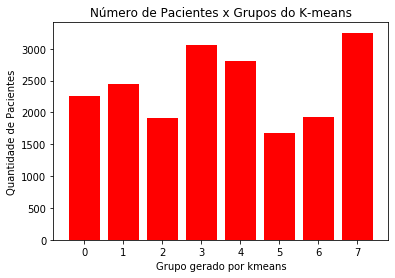

In [29]:
classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,num_otimo_clusters):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem1_pacientes_por_grupos.svg',format="svg")
plt.show()


In [30]:

#fig.savefig('diastolica_sistolica/qtd_x_grupos_dist_sist.png', format='png')

In [31]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [32]:
#treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### VALIDAÇÃO

In [33]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [34]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [35]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5,6,7
0,1337,0,0,0,0,0,0,0
1,0,1465,0,0,0,0,0,0
2,0,0,1147,0,0,0,0,0
3,0,0,0,1801,0,0,0,0
4,0,0,0,0,1656,0,0,0
5,0,0,0,0,0,1033,0,0
6,0,0,0,0,0,0,1181,0
7,0,0,0,0,0,0,0,1979


#### TESTE

In [36]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [37]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9241013705715024 - Recall: 0.9281499836051975 - F1 Score: 0.9271139983664138


In [38]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5,6,7
0,871,9,16,9,1,0,1,8
1,7,924,11,12,8,0,1,13
2,18,25,700,12,11,2,1,0
3,23,26,8,1084,25,16,11,59
4,0,7,16,15,1095,1,1,12
5,1,3,3,11,3,606,12,7
6,2,1,0,10,1,6,727,8
7,11,21,0,52,23,14,13,1140


In [39]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_s_d, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_s_d, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')


KeyError: "None of [Index(['numero_identificacao'], dtype='object')] are in the [columns]"

#### Features Random Forest

In [ ]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_sist_diast,'importance':np.round(random_forest.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False).set_index('features')

In [ ]:
importancia


In [ ]:
#importances.to_excel('diastolica_sistolica/features_sisto_diasto.xlsx')

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

# Abordagem 2: Estatisticas como entrada

In [ ]:
#selecionando variaveis estatisticas

ls_estatistica = list(dataset.loc[:,'Media Sistolica em 24h':'DP Diastolica em 24h'].columns)
dados_estatistica = dataset.loc[:,'Media Sistolica em 24h':'DP Diastolica em 24h']


In [ ]:
#tratar nulos
dados_estatistica_sem_nan = dados_estatistica.fillna(0)

In [ ]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
sum_of_squares = calculate_wcss(dados_estatistica_sem_nan)
n = optimal_number_of_clusters(sum_of_squares)

In [ ]:
#convertendo os dados para a clusterização
X = np.array(dados_estatistica_sem_nan)

In [ ]:
#habilitando o kmeans com 7 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=n, random_state=0).fit(X)

In [ ]:
#listar os grupos 
grupos = kmeans.fit_predict(X)

In [ ]:
#incluir grupos nos dados de sist e diast
dados_estatistica_sem_nan['grupo'] = grupos

In [ ]:
#metodo Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Metodo Elbow Para Otimizar k')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_estatistica_{n_clusters}.svg', format="svg")
#fig.savefig('estatisticas/estatisticas_elbow.png', format='png')
plt.show()

In [ ]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans em dados de amostra"
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_estatistica_{n_clusters}.svg', format="svg")
    #fig.savefig('estatisticas/estatisticas_kmeans_'+str(n_clusters)+'.png', format='png')

plt.show()

#fig.savefig('kmeans_estatisticas.png', format='png')

In [ ]:
#dataset com grupos e por estatisticas
dataset_estatistica = dataset
dataset_estatistica['grupos'] = grupos
dataset_estatistica

In [ ]:
dataset_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')

#dataset_estatistica.to_csv('estatisticas/dataset_estatistica.csv')

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=100)

In [ ]:
#base para modelo

In [ ]:
classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans (estatisticas)')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem2_estatistica_por_grupos.svg',format="svg")
plt.show()

In [ ]:
#salvar a imagem
#fig.savefig('estatisticas/qtd_x_grupos_estatisticas.png', format='png')

In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [ ]:
#treino
random_forest.fit(x_train, y_train)

#### VALIDAÇÃO

In [ ]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [ ]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [ ]:
#Matriz da Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

#### TESTE

In [ ]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [ ]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [ ]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

In [ ]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_estatistica, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_estatistica, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_estatistica = x_val_[['numero_identificacao']]
pacientes_validacao_estatistica['Grupo_Real'] = y_val_
pacientes_validacao_estatistica['Grupo_Previsto'] = y_prev_val
pacientes_validacao_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


#teste
pacientes_teste_estatistica = x_test_[['numero_identificacao']]
pacientes_teste_estatistica['Grupo_Real'] = y_test_
pacientes_teste_estatistica['Grupo_Previsto'] = y_prev_test
pacientes_teste_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


#### Features Random Forest

In [ ]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_estatistica,'importance':np.round(random_forest.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False).set_index('features')

In [ ]:
importancia

In [ ]:
importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


# Abordagem 3: Padrão de Doenças como entrada

In [ ]:
#selecionando padrões de doencas
#dataset.iloc[:,172:183].columns

ls_padroes_doencas = ['Hipotensao', 'Sistolica Isolada', 'Diastolica Isolada', 'Dipping',
       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping', 'Morning Surge',
       'Masked', 'Whitecoat', 'Normotenso']

dados_padrao_doencas =  dataset[ls_padroes_doencas]

In [ ]:
#tratar nulos
dados_padrao_doencas_sem_nan = dados_padrao_doencas.fillna(0)
dados_padrao_doencas_sem_nan

In [ ]:
#trocar nulos do dataframe
d_p_d = dados_padrao_doencas_sem_nan

In [ ]:
#Trocar True e False para 1 e 0
d_p_d['Hipotensao'] = d_p_d['Hipotensao'].apply(verdadeiro_falso)
d_p_d['Sistolica Isolada'] = d_p_d['Sistolica Isolada'].apply(verdadeiro_falso)
d_p_d['Diastolica Isolada'] = d_p_d['Diastolica Isolada'].apply(verdadeiro_falso)
d_p_d['Dipping'] = d_p_d['Dipping'].apply(verdadeiro_falso)
d_p_d['Non Dipping'] = d_p_d['Non Dipping'].apply(verdadeiro_falso)
d_p_d['Extreme Dipping'] = d_p_d['Extreme Dipping'].apply(verdadeiro_falso)
d_p_d['Reverse Dipping'] = d_p_d['Reverse Dipping'].apply(verdadeiro_falso)
d_p_d['Morning Surge'] = d_p_d['Morning Surge'].apply(verdadeiro_falso)
d_p_d['Masked'] = d_p_d['Masked'].apply(verdadeiro_falso)
d_p_d['Whitecoat'] = d_p_d['Whitecoat'].apply(verdadeiro_falso)
d_p_d['Normotenso'] = d_p_d['Normotenso'].apply(verdadeiro_falso)

In [ ]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
sum_of_squares = calculate_wcss(d_p_d)
n = optimal_number_of_clusters(sum_of_squares)

In [ ]:
#convertendo os dados para a clusterização
X = np.array(d_p_d)

In [ ]:
#habilitando o kmeans com 7 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=n, random_state=0).fit(X)

In [ ]:
#listar os grupos 
grupos = kmeans.fit_predict(X)

In [ ]:
#incluir grupos nos dados de padrão de doença
dados_padrao_doencas =  dataset[ls_padroes_doencas]
dados_padrao_doencas_sem_nan = dados_padrao_doencas.fillna(0)
dados_padrao_doencas_sem_nan['grupo'] = grupos

In [ ]:
#metodo Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Metodo Elbow Para Otimizar k')
fig = plt.gcf()
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_doenca_{n_clusters}.svg', format="svg")
plt.show()

In [ ]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans em dados de amostra"
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_doenca_{n_clusters}.svg', format="svg")
    #fig.savefig('padrao_doencas/padrao_doencas_kmeans_'+str(n_clusters)+'.png', format='png')  

plt.show()

#fig.savefig('kmeans_padroes_doencas.png', format='png')

In [ ]:
#dataset com grupos e por padrão de doencas
dataset_padrao_doenca = dataset
dataset_padrao_doenca['grupos'] = grupos
dataset_padrao_doenca

In [ ]:
dataset_padrao_doenca.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')


###  Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=100)

In [ ]:
#base para modelo

In [ ]:
classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans (Padrao de Doencas)')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem3_doenca_por_grupos.svg',format="svg")
plt.show()

In [ ]:
#salvar a imagem
#fig.savefig('padrao_doencas/qtd_x_padrao_doencas.png', format='png')

In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [ ]:
#treino
random_forest.fit(x_train, y_train)

#### VALIDAÇÃO

In [ ]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [ ]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [ ]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

#### TESTE

In [ ]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [ ]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [ ]:
#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

In [ ]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação e teste
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_padrao_doenca, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_padrao_doenca, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_padrao_doencas = x_val_[['numero_identificacao']]
pacientes_validacao_padrao_doencas['Grupo_Real'] = y_val_
pacientes_validacao_padrao_doencas['Grupo_Previsto'] = y_prev_val
pacientes_validacao_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_padrao_doencas = x_test_[['numero_identificacao']]
pacientes_teste_padrao_doencas['Grupo_Real'] = y_test_
pacientes_teste_padrao_doencas['Grupo_Previsto'] = y_prev_test
pacientes_teste_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')


#### Features Random Forest

In [ ]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_padroes_doencas,'importance':np.round(random_forest.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False).set_index('features')

In [ ]:
importancia

In [ ]:
importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')
